# GPT

### This notebook is inspired by https://github.com/yandexdataschool/nlp_course
#### Let's build a GPT model using numpy only

In [1]:
from abc import ABC, abstractmethod
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Union
from IPython.display import HTML, clear_output
np.random.seed(42)
%matplotlib inline

In [2]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./data/arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:128], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

#### We're doing char-level

In [3]:
tokens = list(set(''.join(lines)))

num_tokens = len(tokens)
print('num_tokens = ', num_tokens)

num_tokens =  136


In [4]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
token_to_id

{'F': 0,
 'Ł': 1,
 'ő': 2,
 '6': 3,
 'Q': 4,
 'à': 5,
 'μ': 6,
 'æ': 7,
 'b': 8,
 'i': 9,
 ':': 10,
 'p': 11,
 'E': 12,
 '<': 13,
 'G': 14,
 ')': 15,
 'h': 16,
 'K': 17,
 'Σ': 18,
 'f': 19,
 'α': 20,
 'Ö': 21,
 'k': 22,
 'I': 23,
 'y': 24,
 'σ': 25,
 'V': 26,
 'e': 27,
 'q': 28,
 ']': 29,
 '\\': 30,
 '_': 31,
 '5': 32,
 'Ü': 33,
 '=': 34,
 'D': 35,
 'ω': 36,
 '`': 37,
 'ô': 38,
 '°': 39,
 'N': 40,
 'd': 41,
 '-': 42,
 'J': 43,
 '%': 44,
 'â': 45,
 '&': 46,
 'γ': 47,
 ' ': 48,
 'w': 49,
 '(': 50,
 't': 51,
 'ρ': 52,
 'é': 53,
 ';': 54,
 'U': 55,
 '0': 56,
 'H': 57,
 '@': 58,
 'A': 59,
 'g': 60,
 'ç': 61,
 '^': 62,
 'n': 63,
 'u': 64,
 '#': 65,
 'ś': 66,
 '+': 67,
 'j': 68,
 'ε': 69,
 'ï': 70,
 'Ω': 71,
 'ä': 72,
 'O': 73,
 'C': 74,
 '9': 75,
 '|': 76,
 'c': 77,
 '{': 78,
 'X': 79,
 'v': 80,
 '8': 81,
 'ã': 82,
 '.': 83,
 'M': 84,
 'm': 85,
 'a': 86,
 '4': 87,
 '/': 88,
 'o': 89,
 '\x7f': 90,
 'T': 91,
 '2': 92,
 'λ': 93,
 'Z': 94,
 's': 95,
 'τ': 96,
 'ö': 97,
 'ê': 98,
 'É': 99,
 '!': 

In [5]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [6]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [7]:
token_to_id[' ']

48

In [8]:
# print('\n'.join(lines[::20000]))
print(to_matrix(lines[::20000], token_to_id))

[[ 48  35  64  86 125  48 112  27  77  64 103 103  27  63  51  48  59  51
   51  27  63  51   9  89  63  48  55  63   9  51  95  48  19  89 103  48
   26   9  95  64  86 125  48   4  64  27  95  51   9  89  63  48  59  63
   95  49  27 103   9  63  60  48  54  48 128  27  48  11 103  89  11  89
   95  27  48  86  63  48  86 103  77  16   9  51  27  77  51  64 103  27
   48  19  89 103  48  26   4  59  48  49  16   9  77  16  48  64  51   9
  125   9 107  27  95  48 103  27  77  64 103 103  27  63  51  48 125  86
   24  27 103 117]
 [ 48 109  86 125  86  63  77   9  63  60  48   8   9  22  27  48  95  16
   86 103   9  63  60  48  95  24  95  51  27  85  95  48  50 109 109 110
  110  15  10  48   9  63  95  51  86  63  77  27  48  60  27  63  27 103
   86  51   9  89  63  48  19 103  89  85  48  51  16  27  48  48  48  74
    9  51   9 109   9  22  27  48  40 116  74  48  41  86  51  86  48  54
   48 109   9  22  27  48  95  16  86 103   9  63  60  48  95  24  95  51
   27  85  95  48  

In [9]:
MAX_LENGTH = max(map(len, lines))
sample = to_matrix(np.random.choice(lines, size=5), token_to_id, max_len=MAX_LENGTH)

## Let's describe all layers that we need
https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#self_attention

You can find proofs for all derivatives (using torch.autograd) [here](https://github.com/RomanSafronenkov/ds_stuff/blob/main/Useful%20Stuff/%D0%A7%D0%B5%D1%80%D0%BD%D0%BE%D0%B2%D0%B8%D0%BA%D0%B8/Layer%20derivatives.ipynb)

In [10]:
class BaseLayer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    def __call__(self, x: np.array, grad: bool = True) -> np.array:
        return self.forward(x, grad)

    @abstractmethod
    def forward(self, x: np.array, grad: bool = True) -> np.array:
        pass

    @abstractmethod
    def backward(self, output_error: np.array) -> np.array:
        pass


class Linear3d(BaseLayer):
    """
    Linear class permorms ordinary FC layer in neural networks
    Parameters:
    n_input - size of input neurons
    n_output - size of output neurons
    Methods:
    set_optimizer(optimizer) - is used for setting an optimizer for gradient descent
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, n_input: int, n_output: int) -> None:
        super().__init__()
        self.input = None
        self.n_input = n_input
        self.n_output = n_output
        self.w = np.random.normal(scale=np.sqrt(2 / (n_input + n_output)), size=(n_input, n_output))
        self.b = np.random.normal(scale=np.sqrt(2 / (n_input + n_output)), size=(1, n_output))

        self.w_optimizer = None
        self.b_optimizer = None

    def set_optimizer(self, optimizer) -> None:
        self.w_optimizer = copy.copy(optimizer)
        self.b_optimizer = copy.copy(optimizer)

        self.w_optimizer.set_weight(self.w)
        self.b_optimizer.set_weight(self.b)

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return np.matmul(x, self.w) + self.b  # the same as @

    def backward(self, output_error: np.array) -> np.array:
        assert self.w_optimizer is not None and self.b_optimizer is not None, 'You should set an optimizer'
        # перемножаем последние 2 измерения друг с другом с помощью matmul и суммируем
        w_grad = np.sum(np.transpose(self.input, (0, 2, 1)) @ output_error, axis=0)
        b_grad = np.sum(output_error, axis=(0, 1))
        input_error = output_error @ self.w.T

        self.w = self.w_optimizer.step(w_grad)
        self.b = self.b_optimizer.step(b_grad)
        return input_error


class Activation(BaseLayer):
    """
    Activation class is used for activation function of the FC layer
    Params:
    activation_function - activation function (e.g. sigmoid, RElU, tanh)
    activation_derivative - derivative of the activation function
    Methods:
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, activation_function: callable, activation_derivative: callable) -> None:
        super().__init__()
        self.input = None
        self.activation = activation_function
        self.derivative = activation_derivative

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return self.activation(x)

    def backward(self, output_error: np.array) -> np.array:
        return output_error * self.derivative(self.input)


class Embedding(BaseLayer):
    def __init__(self, n_input, emb_dim, pad_idx=None):
        self.n_input = n_input
        self.emb_dim = emb_dim
        self.pad_idx = pad_idx
        
        self.weights = np.random.normal(scale=np.sqrt(2/(n_input+emb_dim)), size=(n_input, emb_dim))

    def set_optimizer(self, optimizer):
        self.weights_optimizer = copy.copy(optimizer)

        self.weights_optimizer.set_weight(self.weights)

    def forward(self, x, grad=True):
        self.input = x
        return self.weights[x]

    def backward(self, output_error):
        weights_grad = np.zeros_like(self.weights)
        input_shape_len = len(self.input.shape)

        if input_shape_len == 2:
            for batch_n, s in enumerate(self.input):
                for i, emb_i in enumerate(s):
                    weights_grad[emb_i] += output_error[batch_n][i]

        elif input_shape_len == 1:
            for i, emb_i in enumerate(self.input):
                weights_grad[emb_i] += output_error[i]

        if self.pad_idx is not None:
            weights_grad[self.pad_idx] = 0

        self.weights = self.weights_optimizer.step(weights_grad)


class SoftMaxLayer3D(BaseLayer):
    def __init__(self):
        self.input = None
        self.forward_result = None

    def forward(self, x, grad=True):
        self.input = x
        exp = np.exp(x)
        self.forward_result = exp / np.sum(exp, axis=-1, keepdims=True)
        return self.forward_result

    def backward(self, output_error):
        "https://binpord.github.io/2021/09/26/softmax_backprop.html"
        return (output_error - (output_error*self.forward_result).sum(axis=-1, keepdims=True)) * self.forward_result

        
class MultiHeadAttentionLayer(BaseLayer):
    def __init__(self, hid_dim: int, n_heads: int) -> None:
        
        assert hid_dim % n_heads == 0
        
        self.input = None
        self.attn_bias = None
        self.attentions = None
        self.q = None
        self.k = None
        self.v = None
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_size = hid_dim // n_heads
        
        self.c_attn = Linear3d(hid_dim, hid_dim * 3)
        self.c_proj = Linear3d(hid_dim, hid_dim)
        self.softmax = SoftMaxLayer3D()

        self.scale = np.sqrt(self.head_size)

    def set_optimizer(self, optimizer) -> None:
        self.c_attn.set_optimizer(optimizer)
        self.c_proj.set_optimizer(optimizer)

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        
        q_k_v = self.c_attn(x)
        self.q = q_k_v[:, :, :self.hid_dim]
        self.k = q_k_v[:, :, self.hid_dim:self.hid_dim*2]
        self.v = q_k_v[:, :, self.hid_dim*2:self.hid_dim*3]
        assert self.q.shape == self.k.shape == self.v.shape == x.shape, "q, k and v must have the same shape as x"

        head_outputs = []
        self.attentions = []
        for head_index in range(self.n_heads):
            head_selector = range(self.head_size * head_index, self.head_size * (head_index + 1))

            head_queries = self.q[..., head_selector]
            head_keys = self.k[..., head_selector]
            head_values = self.v[..., head_selector]

            single_head_output = self._attention_for_head(
                head_queries, head_keys, head_values,
                is_causal=True)
            head_outputs.append(single_head_output)

        combined_head_outputs = np.concatenate(head_outputs, axis=-1)
        return self.c_proj(combined_head_outputs)

    def _attention_for_head(self, query, key, value, is_causal=False):
        L, S = query.shape[-2], key.shape[-2]
        self.attn_bias = np.zeros((L, S), dtype=query.dtype)
        if is_causal:
            temp_mask = np.tril(np.ones((L, S)))
            self.attn_bias = np.where(temp_mask==0, float('-inf'), 0)
            self.attn_bias = self.attn_bias.astype(query.dtype)
    
        attn_weight = query @ key.transpose(0, 2, 1) / self.scale
        attn_weight += self.attn_bias
        
        attn_weight = self.softmax(attn_weight)
        self.attentions.append(attn_weight)
        
        result = attn_weight @ value

        # result = self.softmax((query @ key.transpose(0, 2, 1) / self.scale) + self.attn_bias) @ value
        
        return result

    def _attention_for_head_grad(self, query, key, value, output_error, head_n):
        # looking at the result expression in the forward pass
        cur_attention = self.attentions[head_n]
        
        v_grad = cur_attention.transpose((0, 2, 1)) @ output_error
        input_error = output_error @ value.transpose((0, 2, 1))

        # we use layer, which uses it's states to calculate grad, so we need to set state that was used during forward pass in current head
        self.softmax.forward_result = cur_attention
        softmax_grad = self.softmax.backward(input_error)

        k_grad = softmax_grad.transpose(0, 2, 1) @ query / self.scale # we need to transpose output error due to the fact key was transposed in forward
        q_grad = softmax_grad @ key / self.scale

        return q_grad, k_grad, v_grad

    def backward(self, output_error: np.array) -> np.array:
        projection_error = self.c_proj.backward(output_error)
        
        q_grads, k_grads, v_grads = [], [], []
        for head_index in range(self.n_heads):
            # for each head we choose it's error
            head_selector = range(self.head_size * head_index, self.head_size * (head_index + 1))

            attention_error = projection_error[..., head_selector]
            head_queries = self.q[..., head_selector]
            head_keys = self.k[..., head_selector]
            head_values = self.v[..., head_selector]

            q_grad, k_grad, v_grad = self._attention_for_head_grad(head_queries, head_keys, head_values, attention_error, head_index)
            q_grads.append(q_grad)
            k_grads.append(k_grad)
            v_grads.append(v_grad)

        q_grads = np.concatenate(q_grads, axis=-1)
        k_grads = np.concatenate(k_grads, axis=-1)
        v_grads = np.concatenate(v_grads, axis=-1)

        q_k_v_output = np.concatenate([q_grads, k_grads, v_grads], axis=-1)
        
        input_error = self.c_attn.backward(q_k_v_output)
        return input_error

        
class LayerNorm(BaseLayer):
    def __init__(self, dim, eps=1e-5, elementwise_affine=True, bias=True):
        self.dim = dim
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        self.use_bias = bias

        self.input = None
        self.normalized = None
        self.mean = None
        self.var = None

        self.weight = np.ones(shape=dim)
        self.bias = np.zeros(shape=dim)

    def set_optimizer(self, optimizer) -> None:
        self.weight_optimizer = copy.copy(optimizer)
        self.bias_optimizer = copy.copy(optimizer)

        self.weight_optimizer.set_weight(self.weight)
        self.bias_optimizer.set_weight(self.bias)

    def forward(self, x, grad=True):
        """Only for -1 axis"""
        self.input = x

        self.mean = np.mean(x, axis=-1, keepdims=True)
        self.var = np.var(x, axis=-1, keepdims=True, ddof=0)
        self.x_centered = (x - self.mean)
        self.std = np.sqrt(self.var+self.eps)

        self.normalized = self.x_centered / self.std

        result = self.normalized * self.weight + self.bias
        return result

    def backward(self, output_error):
        weight_grad = None
        bias_grad = None
        if self.elementwise_affine:
            weight_grad = np.sum(output_error * self.normalized, axis=(0, 1))

        if self.use_bias:
            bias_grad = np.sum(output_error, axis=(0, 1))

        # производная по normalized
        dldx = output_error * self.weight
        # производная по дисперсии в знаменателе
        dldsigma2 = np.sum(dldx * self.x_centered * (-1/2) * (self.std ** -3), axis=-1, keepdims=True)
        dldmu = np.sum((dldx * (-1/self.std)), axis=-1, keepdims=True) + dldsigma2\
        * np.sum(-2*self.x_centered, axis=-1, keepdims=True) / self.dim

        input_error = dldx / self.std + dldsigma2 * 2 * self.x_centered / self.dim + dldmu / self.dim

        self.weight = self.weight_optimizer.step(weight_grad)
        self.bias = self.bias_optimizer.step(bias_grad)
        return input_error


class FullyConnected(BaseLayer):
    def __init__(self, dim):
        self.c_fc = Linear3d(dim, 4*dim)
        self.relu = Activation(relu, relu_derivative)
        self.c_proj = Linear3d(4*dim, dim)

    def set_optimizer(self, optimizer):
        self.c_fc.set_optimizer(optimizer)
        self.c_proj.set_optimizer(optimizer)

    def forward(self, x, grad=True):
        outputs = self.c_fc(x)

        outputs = self.relu(outputs)

        outputs = self.c_proj(outputs)
        return outputs

    def backward(self, output_error):
        c_proj_error = self.c_proj.backward(output_error)
        relu_error = self.relu.backward(c_proj_error)
        c_fc_error = self.c_fc.backward(relu_error)

        return c_fc_error

![](https://i.imgur.com/1sq2vHO.png)

In [ ]:
class Transformer(BaseLayer):
    def __init__(self, dim: int, num_heads: int):
        self.ln_1 = LayerNorm(dim)
        self.attn = MultiHeadAttentionLayer(dim, num_heads)
        self.ln_2 = LayerNorm(dim)
        self.mlp = FullyConnected(dim)

    def set_optimizer(self, optimizer):
        self.ln_1.set_optimizer(optimizer)
        self.attn.set_optimizer(optimizer)
        self.ln_2.set_optimizer(optimizer)
        self.mlp.set_optimizer(optimizer)

    def forward(self, x, grad=True):
        output1 = self.ln_1(x)
        output1 = self.attn(output1)
        output1 = output1 + x

        output2 = self.ln_2(output1)
        output2 = self.mlp(output2)
        output = output2 + output1
        return output

    def backward(self, output_error):
        # output = output1 + output2 + x
        # doutput_doutput2 = 1 и надо это умножить на output_error
        mlp_error = self.mlp.backward(output_error)
        ln2_error = self.ln_2.backward(mlp_error)
        # doutput_doutput1 = 1 и надо это умножить на output_error + ошибка, которая пришла выше
        
        attn_error = self.attn.backward(ln2_error+output_error) 
        ln1_error = self.ln_1.backward(attn_error)
        # doutput_dx = 1 и надо это умножить на output_error + ошибка, которая пришла выше
        
        return ln1_error+ln2_error+output_error

In [11]:
def relu(z: Union[np.array, float, int, list]) -> Union[np.array, float, int]:
    """
    ReLU function
    """
    return np.maximum(0, z)


def relu_derivative(z: Union[np.array, float, int, list]) -> np.array:
    """
    ReLU function derivative
    """
    return (z > 0).astype(int)

def cross_entropy_loss(y_true: np.array, a_pred: np.array) -> float:
    """
    CrossEntropyLoss for multi-classification tasks
    :param y_true: 2D vector with classes, i.e. [[0], [3], [4], [1], [2]]
    :param a_pred: scores for each class before softmax function with shape [n_samples, n_classes]
    :return: CrossEntropyLoss
    """
    lenght_y = list(range(len(y_true)))
    arg = -a_pred[lenght_y, y_true.ravel()]
    sum_exp = np.sum(np.exp(a_pred), axis=1)
    loss = np.sum(arg + np.log(sum_exp))
    return loss / len(y_true)

def cross_entropy_loss_derivative(y_true: np.array, a_pred: np.array) -> np.array:
    """
    CrossEntropyLoss derivative for multi-classification tasks
    :param y_true: 2D vector with classes, i.e. [[0], [3], [4], [1], [2]]
    :param a_pred: scores for each class before softmax function with shape [n_samples, n_classes]
    :return: np.array with shape [n_samples, n_classes] with CrossEntropyLoss derivatives for each weight
    """
    lenght_y = list(range(len(y_true)))
    sum_exp = np.sum(np.exp(a_pred), axis=1).reshape(-1, 1)
    loss = np.exp(a_pred.copy()) / sum_exp
    loss[lenght_y, y_true.ravel()] -= 1

    return loss / len(y_true)

In [ ]:
class BaseOptimizer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    @abstractmethod
    def set_weight(self, weight: np.array) -> None:
        pass

    @abstractmethod
    def step(self, grad: np.array) -> np.array:
        pass


class ADAM(BaseOptimizer):
    """
    Implements Adam algorithm.

    learning_rate (float, optional) – learning rate (default: 1e-3)
    beta1, beta2 (Tuple[float, float], optional) –
    coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    eps (float, optional) – term added to the denominator to improve numerical stability (default: 1e-8)
    """

    def __init__(self, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8,
                 learning_rate: float = 3e-4, weight_decay: float = 0) -> None:
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        self.EMA1 = None
        self.EMA2 = None

        self.weight = None

    def set_weight(self, weight: np.array) -> None:
        self.weight = weight.copy()
        self.EMA1 = np.zeros(shape=self.weight.shape)
        self.EMA2 = np.zeros(shape=self.weight.shape)

    def step(self, grad: np.array) -> np.array:
        assert self.weight is not None, 'You should set the weight'
        grad = grad.copy() + self.weight_decay * self.weight
        self.EMA1 = (1 - self.beta1) * grad + self.beta1 * self.EMA1
        self.EMA2 = (1 - self.beta2) * grad ** 2 + self.beta2 * self.EMA2
        self.weight -= self.learning_rate * self.EMA1 / (np.sqrt(self.EMA2) + self.eps)

        return self.weight.copy()


In [27]:
class GPT:
    def __init__(self, vocab_size: int, dim: int, num_heads: int, num_layers: int, max_position_embeddings: int = 256):
        self.wte = Embedding(vocab_size, dim)  # token embeddings
        self.wpe = Embedding(max_position_embeddings, dim)  # position embeddings
        self.ln_f = LayerNorm(dim)   # final layer norm - goes after all transformer layers, but before logits

        self.h = [Transformer(dim, num_heads) for layer in range(num_layers)]
        self.to_logits = Linear3d(dim, vocab_size)

    def set_optimizer(self, optimizer):
        self.wte.set_optimizer(optimizer)
        self.wpe.set_optimizer(optimizer)
        self.ln_f.set_optimizer(optimizer)
        self.to_logits.set_optimizer(optimizer)

        for layer in self.h:
            layer.set_optimizer(optimizer)

    def __call__(self, input_ids):
        return self.forward(input_ids)

    def forward(self, input_ids):
        # input_ids.shape: [batch_size, sequence_length], int64 token ids
        position_ids = np.arange(input_ids.shape[1])[None, ...]

        token_embeddings = self.wte(input_ids)
        position_embeddings = self.wpe(position_ids)
        full_embeddings = token_embeddings + position_embeddings

        transformer_output = full_embeddings
        for transformer_layer in self.h:
            transformer_output = transformer_layer(transformer_output)
        transformer_output_ln = self.ln_f(transformer_output)

        # final layer: we predict logits by re-using token embeddings as linear weights
        output_logits = self.to_logits(transformer_output_ln)
        return output_logits

    def backward(self, output_error):
        logits_error = self.to_logits.backward(output_error)

        transformer_error = logits_error
        for transformer_layer in reversed(self.h):
            transformer_error = transformer_layer.backward(transformer_error)

        self.wte.backward(transformer_error)
        self.wpe.backward(transformer_error)

# Training transformer might be tricky
![](./images/how_to_train_lm.gif)

In [36]:
dim = 128
num_heads = 8
num_layers = 2

optimizer = ADAM(learning_rate=0.001)
model = GPT(vocab_size=len(token_to_id), dim=dim, num_heads=num_heads, num_layers=num_layers)
model.set_optimizer(optimizer)

![](./images/nan.jpg)

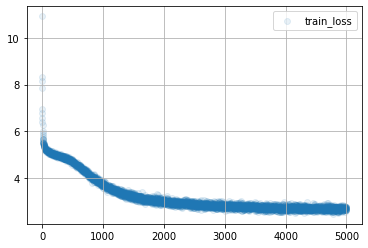

In [37]:
batch_size = 64
train_history = []
for i in range(5000):
    batch_ix = to_matrix(np.random.choice(lines, size=batch_size, replace=False), token_to_id, max_len=MAX_LENGTH)
    
    pred = model(batch_ix[:, :-1])

    loss = 0
    for t in range(batch_ix.shape[1]-1):
        loss += cross_entropy_loss(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])
        
    errors = np.zeros(shape=(batch_size, MAX_LENGTH-1, len(token_to_id)))
    for t in range(errors.shape[1]-1):
        errors[:, t, :] = cross_entropy_loss_derivative(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])
    
    err = model.backward(errors)
    
    # visualizing training process
    assert not np.isnan(loss), 'loss is nan'
    train_history.append((i, loss / batch_size))
    if (i + 1) % 10 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        plt.legend(); plt.grid(); plt.show()

In [40]:
train_history[-1]

(4999, 2.7049051480273785)

In [38]:
softmax = SoftMaxLayer3D()
def generate_sample(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    phrase = copy.copy(seed_phrase)
    
    for t in range(len(seed_phrase)-1, max_length-len(seed_phrase)):
        x_sequence = to_matrix([phrase], token_to_id, max_len=max_length)

        pred = model(x_sequence)
        probs = softmax(pred[:, t] / temperature).ravel()
        next_ix = np.random.choice(len(tokens), p=probs)
        phrase += tokens[next_ix]
    return phrase

In [39]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=' ', temperature=0.5))

 A Sent Algorithm for Expert Semantics ; The problem of a sensore of the problem of unital probabilistic interencests of solve eva
 Contextual Reduction Semantics ; Deep Learning algorithm for image the sensors of the longuage specification of deep neural netwa
 A Conving of Distributed Sentence Memory ; The of a new with attention main maps of an application machine of a propagation betwe
 Computational Inference for Optimization of Words ; We sensitive the the study of probabilistic process with a semantic sensity s
 A Spatial Attentive Deep Learning for Sensor Spectral Terministic   Segmentation ; The predict of the is the imilar as a pose ari
 Proception of Modular Continuous of Subspectanal Scalares ; This paper presents the a serieval proposal with an algorithm for a a
 Automatic Discussive Avarial Networks ; We present a in the bailmited of the controllect unifiered for related of processing thea
 Learning an State-Sembetic Between Accuracy Model ; We present of the problem of s